## Load libraries

In [95]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.utils import class_weight
from sklearn.metrics import recall_score, precision_score, f1_score, classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU, Embedding, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

from gensim.models import Word2Vec

from warnings import filterwarnings
filterwarnings('ignore')


In [96]:
def eval_metrics(model, X_train, X_test):
    y_pred = model.predict(X_test)
    y_pred_train = model.predict(X_train)
    print('\0033[1m' + 'Test Set:' + '\033[0m')
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    print('\0033[1m' + 'Trajn Set:' + '\033[0m')
    print(confusion_matrix(y_train, y_pred_train))
    print(classification_report(y_train, y_pred_train))    

## Loading the Data

In [97]:
df = pd.read_pickle('clean_data_1608221436.pkl')

df['clean_text_lemmas'] = [' '.join(text) for text in df['lemmas']]
df['clean_text_lemmas'] = df['clean_text_lemmas'].astype('str')

In [98]:
# Subset the features and target
X = df.clean_text_lemmas
y = df.target

In [99]:
# Perform a test/train split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size=0.3, random_state=42)

## Vectorization

In [100]:
# Vectorizer the data
vectorizer = TfidfVectorizer(ngram_range=(1,2), max_df=0.8, min_df=5)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

## Classifiers

## Logistics Regression

In [101]:
# Set seed for reproductibility
np.random.seed(42)

logreg = LogisticRegression()

# Create hyperparameter grid

C = np.logspace(-1, 5, 20)
solver = ['liblinear', 'lbfgs', 'saga', 'sag']
class_weight = ['balanced', None]

params = {'C': C,
            'solver' : solver,
            'class_weight': class_weight}

grid_logreg = GridSearchCV(estimator=logreg,
                            param_grid=params, cv=10,
                            verbose=2,
                            scoring='accuracy')

In [102]:
grid_logreg.fit(X_train_vec, y_train)

Fitting 10 folds for each of 160 candidates, totalling 1600 fits
[CV] END .....C=0.1, class_weight=balanced, solver=liblinear; total time=   0.0s
[CV] END .....C=0.1, class_weight=balanced, solver=liblinear; total time=   0.0s
[CV] END .....C=0.1, class_weight=balanced, solver=liblinear; total time=   0.0s
[CV] END .....C=0.1, class_weight=balanced, solver=liblinear; total time=   0.0s
[CV] END .....C=0.1, class_weight=balanced, solver=liblinear; total time=   0.0s
[CV] END .....C=0.1, class_weight=balanced, solver=liblinear; total time=   0.0s
[CV] END .....C=0.1, class_weight=balanced, solver=liblinear; total time=   0.0s
[CV] END .....C=0.1, class_weight=balanced, solver=liblinear; total time=   0.0s
[CV] END .....C=0.1, class_weight=balanced, solver=liblinear; total time=   0.0s
[CV] END .....C=0.1, class_weight=balanced, solver=liblinear; total time=   0.0s
[CV] END .........C=0.1, class_weight=balanced, solver=lbfgs; total time=   0.0s
[CV] END .........C=0.1, class_weight=balanc

GridSearchCV(cv=10, estimator=LogisticRegression(),
             param_grid={'C': array([1.00000000e-01, 2.06913808e-01, 4.28133240e-01, 8.85866790e-01,
       1.83298071e+00, 3.79269019e+00, 7.84759970e+00, 1.62377674e+01,
       3.35981829e+01, 6.95192796e+01, 1.43844989e+02, 2.97635144e+02,
       6.15848211e+02, 1.27427499e+03, 2.63665090e+03, 5.45559478e+03,
       1.12883789e+04, 2.33572147e+04, 4.83293024e+04, 1.00000000e+05]),
                         'class_weight': ['balanced', None],
                         'solver': ['liblinear', 'lbfgs', 'saga', 'sag']},
             scoring='accuracy', verbose=2)

In [103]:
print(grid_logreg.best_params_)
print(grid_logreg.best_score_)
log_model = grid_logreg.best_score_

{'C': 1.8329807108324356, 'class_weight': None, 'solver': 'liblinear'}
0.79283069305534


In [174]:
eval_metrics(grid_logreg, X_train_vec, X_test_vec)

3Test Set:
[[1147  156]
 [ 291  690]]
              precision    recall  f1-score   support

           0       0.80      0.88      0.84      1303
           1       0.82      0.70      0.76       981

    accuracy                           0.80      2284
   macro avg       0.81      0.79      0.80      2284
weighted avg       0.81      0.80      0.80      2284

3Trajn Set:
[[2839  200]
 [ 509 1781]]
              precision    recall  f1-score   support

           0       0.85      0.93      0.89      3039
           1       0.90      0.78      0.83      2290

    accuracy                           0.87      5329
   macro avg       0.87      0.86      0.86      5329
weighted avg       0.87      0.87      0.87      5329



## BernoulliNB

In [106]:
# Set seed for reproductibility
np.random.seed(42)

nb = BernoulliNB()

# Create hyperparameter grid

alpha = [0.01, 0.1, 0.5, 1, 10]

params = {'alpha': alpha}

grid_nb = GridSearchCV(estimator=nb,
                            param_grid=params, cv=10,
                            verbose=2,
                            scoring='accuracy')

In [107]:
grid_nb.fit(X_train_vec, y_train)

Fitting 10 folds for each of 5 candidates, totalling 50 fits
[CV] END .........................................alpha=0.01; total time=   0.0s
[CV] END .........................................alpha=0.01; total time=   0.0s
[CV] END .........................................alpha=0.01; total time=   0.0s
[CV] END .........................................alpha=0.01; total time=   0.0s
[CV] END .........................................alpha=0.01; total time=   0.0s
[CV] END .........................................alpha=0.01; total time=   0.0s
[CV] END .........................................alpha=0.01; total time=   0.0s
[CV] END .........................................alpha=0.01; total time=   0.0s
[CV] END .........................................alpha=0.01; total time=   0.0s
[CV] END .........................................alpha=0.01; total time=   0.0s
[CV] END ..........................................alpha=0.1; total time=   0.0s
[CV] END .......................................

GridSearchCV(cv=10, estimator=BernoulliNB(),
             param_grid={'alpha': [0.01, 0.1, 0.5, 1, 10]}, scoring='accuracy',
             verbose=2)

In [108]:
print(grid_nb.best_params_)
print(grid_nb.best_score_)
nb_model = grid_nb.best_score_

{'alpha': 0.5}
0.789452524369084


## SVM

In [109]:
# Set seed for reproductibility
np.random.seed(42)

svc = LinearSVC()

# Create hyperparameter grid

C = [0.01, 0.1, 0.5, 1, 10, 100]
loss = ['hinge', 'squared_hinge']
penalty = ['l1', 'l2']
class_weight = ['balanced', None]

params = {'C': C,
            'loss' : loss,
            'penalty' : penalty,
            'class_weight': class_weight}

grid_svc = GridSearchCV(estimator=svc,
                            param_grid=params, cv=10,
                            verbose=2,
                            scoring='accuracy')

In [110]:
grid_svc.fit(X_train_vec, y_train)

Fitting 10 folds for each of 48 candidates, totalling 480 fits
[CV] END C=0.01, class_weight=balanced, loss=hinge, penalty=l1; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, loss=hinge, penalty=l1; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, loss=hinge, penalty=l1; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, loss=hinge, penalty=l1; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, loss=hinge, penalty=l1; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, loss=hinge, penalty=l1; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, loss=hinge, penalty=l1; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, loss=hinge, penalty=l1; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, loss=hinge, penalty=l1; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, loss=hinge, penalty=l1; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, loss=hinge, penalty=l2; total time=   0.0s
[CV] END C=0.01, class_w

GridSearchCV(cv=10, estimator=LinearSVC(),
             param_grid={'C': [0.01, 0.1, 0.5, 1, 10, 100],
                         'class_weight': ['balanced', None],
                         'loss': ['hinge', 'squared_hinge'],
                         'penalty': ['l1', 'l2']},
             scoring='accuracy', verbose=2)

In [111]:
print(grid_svc.best_params_)
print(grid_svc.best_score_)
svc_model = grid_svc.best_score_

{'C': 0.1, 'class_weight': None, 'loss': 'squared_hinge', 'penalty': 'l2'}
0.7928289297352199


## KNN

In [118]:
# Set seed for reproductibility
np.random.seed(42)

knn = KNeighborsClassifier()

# Create hyperparameter grid

n_neighbors = range(1,30)
p = [1, 2]
weights = ['uniform', 'distance']

params = {'n_neighbors': n_neighbors,
            'p' : p,
            'weights': weights}

grid_knn = GridSearchCV(estimator=knn,
                            param_grid=params, cv=10,
                            verbose=2,
                            scoring='accuracy')

In [119]:
grid_knn.fit(X_train_vec, y_train)

Fitting 10 folds for each of 116 candidates, totalling 1160 fits
[CV] END ................n_neighbors=1, p=1, weights=uniform; total time=   0.1s
[CV] END ................n_neighbors=1, p=1, weights=uniform; total time=   0.1s
[CV] END ................n_neighbors=1, p=1, weights=uniform; total time=   0.1s
[CV] END ................n_neighbors=1, p=1, weights=uniform; total time=   0.1s
[CV] END ................n_neighbors=1, p=1, weights=uniform; total time=   0.1s
[CV] END ................n_neighbors=1, p=1, weights=uniform; total time=   0.1s
[CV] END ................n_neighbors=1, p=1, weights=uniform; total time=   0.1s
[CV] END ................n_neighbors=1, p=1, weights=uniform; total time=   0.0s
[CV] END ................n_neighbors=1, p=1, weights=uniform; total time=   0.1s
[CV] END ................n_neighbors=1, p=1, weights=uniform; total time=   0.1s
[CV] END ...............n_neighbors=1, p=1, weights=distance; total time=   0.0s
[CV] END ...............n_neighbors=1, p=1, 

GridSearchCV(cv=10, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': range(1, 30), 'p': [1, 2],
                         'weights': ['uniform', 'distance']},
             scoring='accuracy', verbose=2)

In [120]:
print(grid_knn.best_params_)
print(grid_knn.best_score_)
knn_model = grid_knn.best_score_

{'n_neighbors': 2, 'p': 2, 'weights': 'distance'}
0.7104508456883296


## Random Forest

In [121]:
# Set seed for reproductibility
np.random.seed(42)

rf = RandomForestClassifier()

# Create hyperparameter grid

n_estimators = [50, 100, 300]
max_features = [2, 3, 4, 'auto']
max_depth = [3, 5, 7, 9]
min_samples_split = [2, 5, 8]
class_weight = ['balanced']

params = {'n_estimators': n_estimators,
            'max_features' : max_features,
            'max_depth': max_depth,
            'min_samples_split': min_samples_split,
            'class_weight' : class_weight}

grid_rf = GridSearchCV(estimator=rf,
                            param_grid=params, cv=10,
                            verbose=2,
                            scoring='accuracy')

In [122]:
grid_rf.fit(X_train_vec, y_train)

Fitting 10 folds for each of 144 candidates, totalling 1440 fits
[CV] END class_weight=balanced, max_depth=3, max_features=2, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END class_weight=balanced, max_depth=3, max_features=2, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END class_weight=balanced, max_depth=3, max_features=2, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END class_weight=balanced, max_depth=3, max_features=2, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END class_weight=balanced, max_depth=3, max_features=2, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END class_weight=balanced, max_depth=3, max_features=2, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END class_weight=balanced, max_depth=3, max_features=2, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END class_weight=balanced, max_depth=3, max_features=2, min_samples_split=2, n_estimators=50; total time

GridSearchCV(cv=10, estimator=RandomForestClassifier(),
             param_grid={'class_weight': ['balanced'],
                         'max_depth': [3, 5, 7, 9],
                         'max_features': [2, 3, 4, 'auto'],
                         'min_samples_split': [2, 5, 8],
                         'n_estimators': [50, 100, 300]},
             scoring='accuracy', verbose=2)

In [123]:
print(grid_rf.best_params_)
print(grid_rf.best_score_)
rf_model = grid_rf.best_score_

{'class_weight': 'balanced', 'max_depth': 9, 'max_features': 2, 'min_samples_split': 5, 'n_estimators': 300}
0.7735029412179605


## Ada Boost

In [124]:
# Set seed for reproductibility
np.random.seed(42)

ada = AdaBoostClassifier()

# Create hyperparameter grid

n_estimators = [20, 30, 100, 200]
learning_rate = [0.01, 0.1, 0.2, 0.5, 1]

params = {'n_estimators': n_estimators,
            'learning_rate' : learning_rate}

grid_ada = GridSearchCV(estimator=ada,
                            param_grid=params, cv=10,
                            verbose=2,
                            scoring='accuracy')

In [125]:
grid_ada.fit(X_train_vec, y_train)

Fitting 10 folds for each of 20 candidates, totalling 200 fits
[CV] END ................learning_rate=0.01, n_estimators=20; total time=   0.3s
[CV] END ................learning_rate=0.01, n_estimators=20; total time=   0.1s
[CV] END ................learning_rate=0.01, n_estimators=20; total time=   0.1s
[CV] END ................learning_rate=0.01, n_estimators=20; total time=   0.1s
[CV] END ................learning_rate=0.01, n_estimators=20; total time=   0.0s
[CV] END ................learning_rate=0.01, n_estimators=20; total time=   0.0s
[CV] END ................learning_rate=0.01, n_estimators=20; total time=   0.0s
[CV] END ................learning_rate=0.01, n_estimators=20; total time=   0.1s
[CV] END ................learning_rate=0.01, n_estimators=20; total time=   0.0s
[CV] END ................learning_rate=0.01, n_estimators=20; total time=   0.0s
[CV] END ................learning_rate=0.01, n_estimators=30; total time=   0.1s
[CV] END ................learning_rate=0.01, n

GridSearchCV(cv=10, estimator=AdaBoostClassifier(),
             param_grid={'learning_rate': [0.01, 0.1, 0.2, 0.5, 1],
                         'n_estimators': [20, 30, 100, 200]},
             scoring='accuracy', verbose=2)

In [126]:
print(grid_ada.best_params_)
print(grid_ada.best_score_)
ada_model = grid_ada.best_score_

{'learning_rate': 0.5, 'n_estimators': 200}
0.7579268292682926


## XGBOOST

In [127]:
# Set seed for reproductibility
np.random.seed(42)

xgb = XGBClassifier()

# Create hyperparameter grid

n_estimators = [50, 100]
learning_rate = [0.1, 0.2]
max_depth = [3, 4, 5]
subsample = [0.5, 1]
colsample_bytree = [0.5, 1]

params = {'n_estimators': n_estimators,
            'learning_rate' : learning_rate,
            'max_depth': max_depth,
            'subsample': subsample,
            'colsample_bytree' : colsample_bytree}

grid_xgb = GridSearchCV(estimator=xgb,
                            param_grid=params, cv=10,
                            verbose=2,
                            scoring='accuracy')

In [128]:
grid_xgb.fit(X_train_vec, y_train)

Fitting 10 folds for each of 48 candidates, totalling 480 fits
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=3, n_estimators=50, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=3, n_estimators=50, subsample=0.5; total time=   0.1s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=3, n_estimators=50, subsample=0.5; total time=   0.1s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=3, n_estimators=50, subsample=0.5; total time=   0.1s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=3, n_estimators=50, subsample=0.5; total time=   0.1s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=3, n_estimators=50, subsample=0.5; total time=   0.1s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=3, n_estimators=50, subsample=0.5; total time=   0.1s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=3, n_estimators=50, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree

GridSearchCV(cv=10,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_c...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                        

In [129]:
print(grid_xgb.best_params_)
print(grid_xgb.best_score_)
xgb_model = grid_xgb.best_score_

{'colsample_bytree': 0.5, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.5}
0.7641192568663686


## Comparing Model Scores

In [130]:
compare = pd.DataFrame({'models' : ['log_model', 'nb_model', 'svc_model', 'knn_model', 'rf_model', 'ada_model', 'xgb_model'],
                        'scores' : [log_model, nb_model, svc_model, knn_model, rf_model, ada_model, xgb_model]})

In [137]:
def labels(ax):
    for p in ax.containers:
        ax.bar_label(p, fmt='%.3f')

In [ ]:
for bars in ax.containers:
    ax.bar_label(bars)

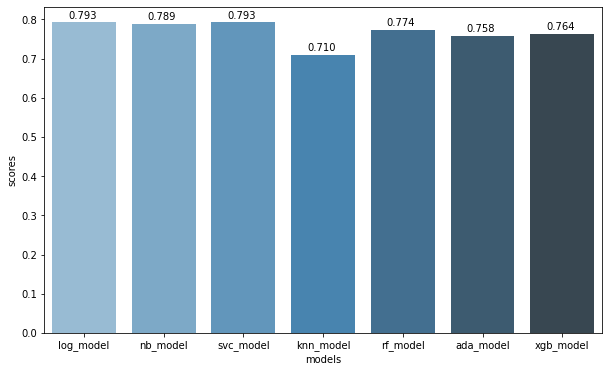

In [171]:
plt.figure(figsize=(10,6))

plt.subplot()
ax=sns.barplot(x='models', y='scores', data=compare, palette='Blues_d')
for p in ax.patches:
    ax.annotate(str(format(p.get_height(), '.3f')), (p.get_x() +0.2 , p.get_height()+0.01))